In [1]:
import soundfile 
import numpy as np
import librosa 
import glob
import os
import pickle 
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def extract_feature(file_name, **kwargs):
    
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [3]:
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}


AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy",
    "fearful",
    "surprised",
    "digust",
    "calm"
}

In [4]:
def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("Data/Actor_*/*.wav"):
        basename = os.path.basename(file)
        emotion = int2emotion[basename.split("-")[2]]
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        features = extract_feature(file, mfcc=True, chroma=True, mel=True)
        X.append(features)
        y.append(emotion)
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [5]:
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

In [6]:
print("[+] Number of training samples:", X_train.shape[0])
print("[+] Number of testing samples:", X_test.shape[0])
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 936
[+] Number of testing samples: 312
[+] Number of features: 180


In [14]:
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}

In [15]:
model = MLPClassifier(**model_params)

In [16]:
print("[*] Training the model...")
model.fit(X_train, y_train)

[*] Training the model...


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [17]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 57.69%


In [18]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       1.00      0.57      0.73        56
        calm       0.58      0.74      0.65        53
     fearful       0.57      0.63      0.60        52
       happy       0.55      0.67      0.60        48
     neutral       0.31      0.40      0.35        25
         sad       0.45      0.31      0.37        42
   surprised       0.58      0.58      0.58        36

    accuracy                           0.58       312
   macro avg       0.58      0.56      0.55       312
weighted avg       0.61      0.58      0.58       312



In [19]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[32  2  6  9  2  0  5]
 [ 0 39  2  0  7  5  0]
 [ 0  0 33  6  4  7  2]
 [ 0  3  5 32  2  3  3]
 [ 0 11  0  1 10  1  2]
 [ 0 10 10  3  3 13  3]
 [ 0  2  2  7  4  0 21]]


0.5769230769230769

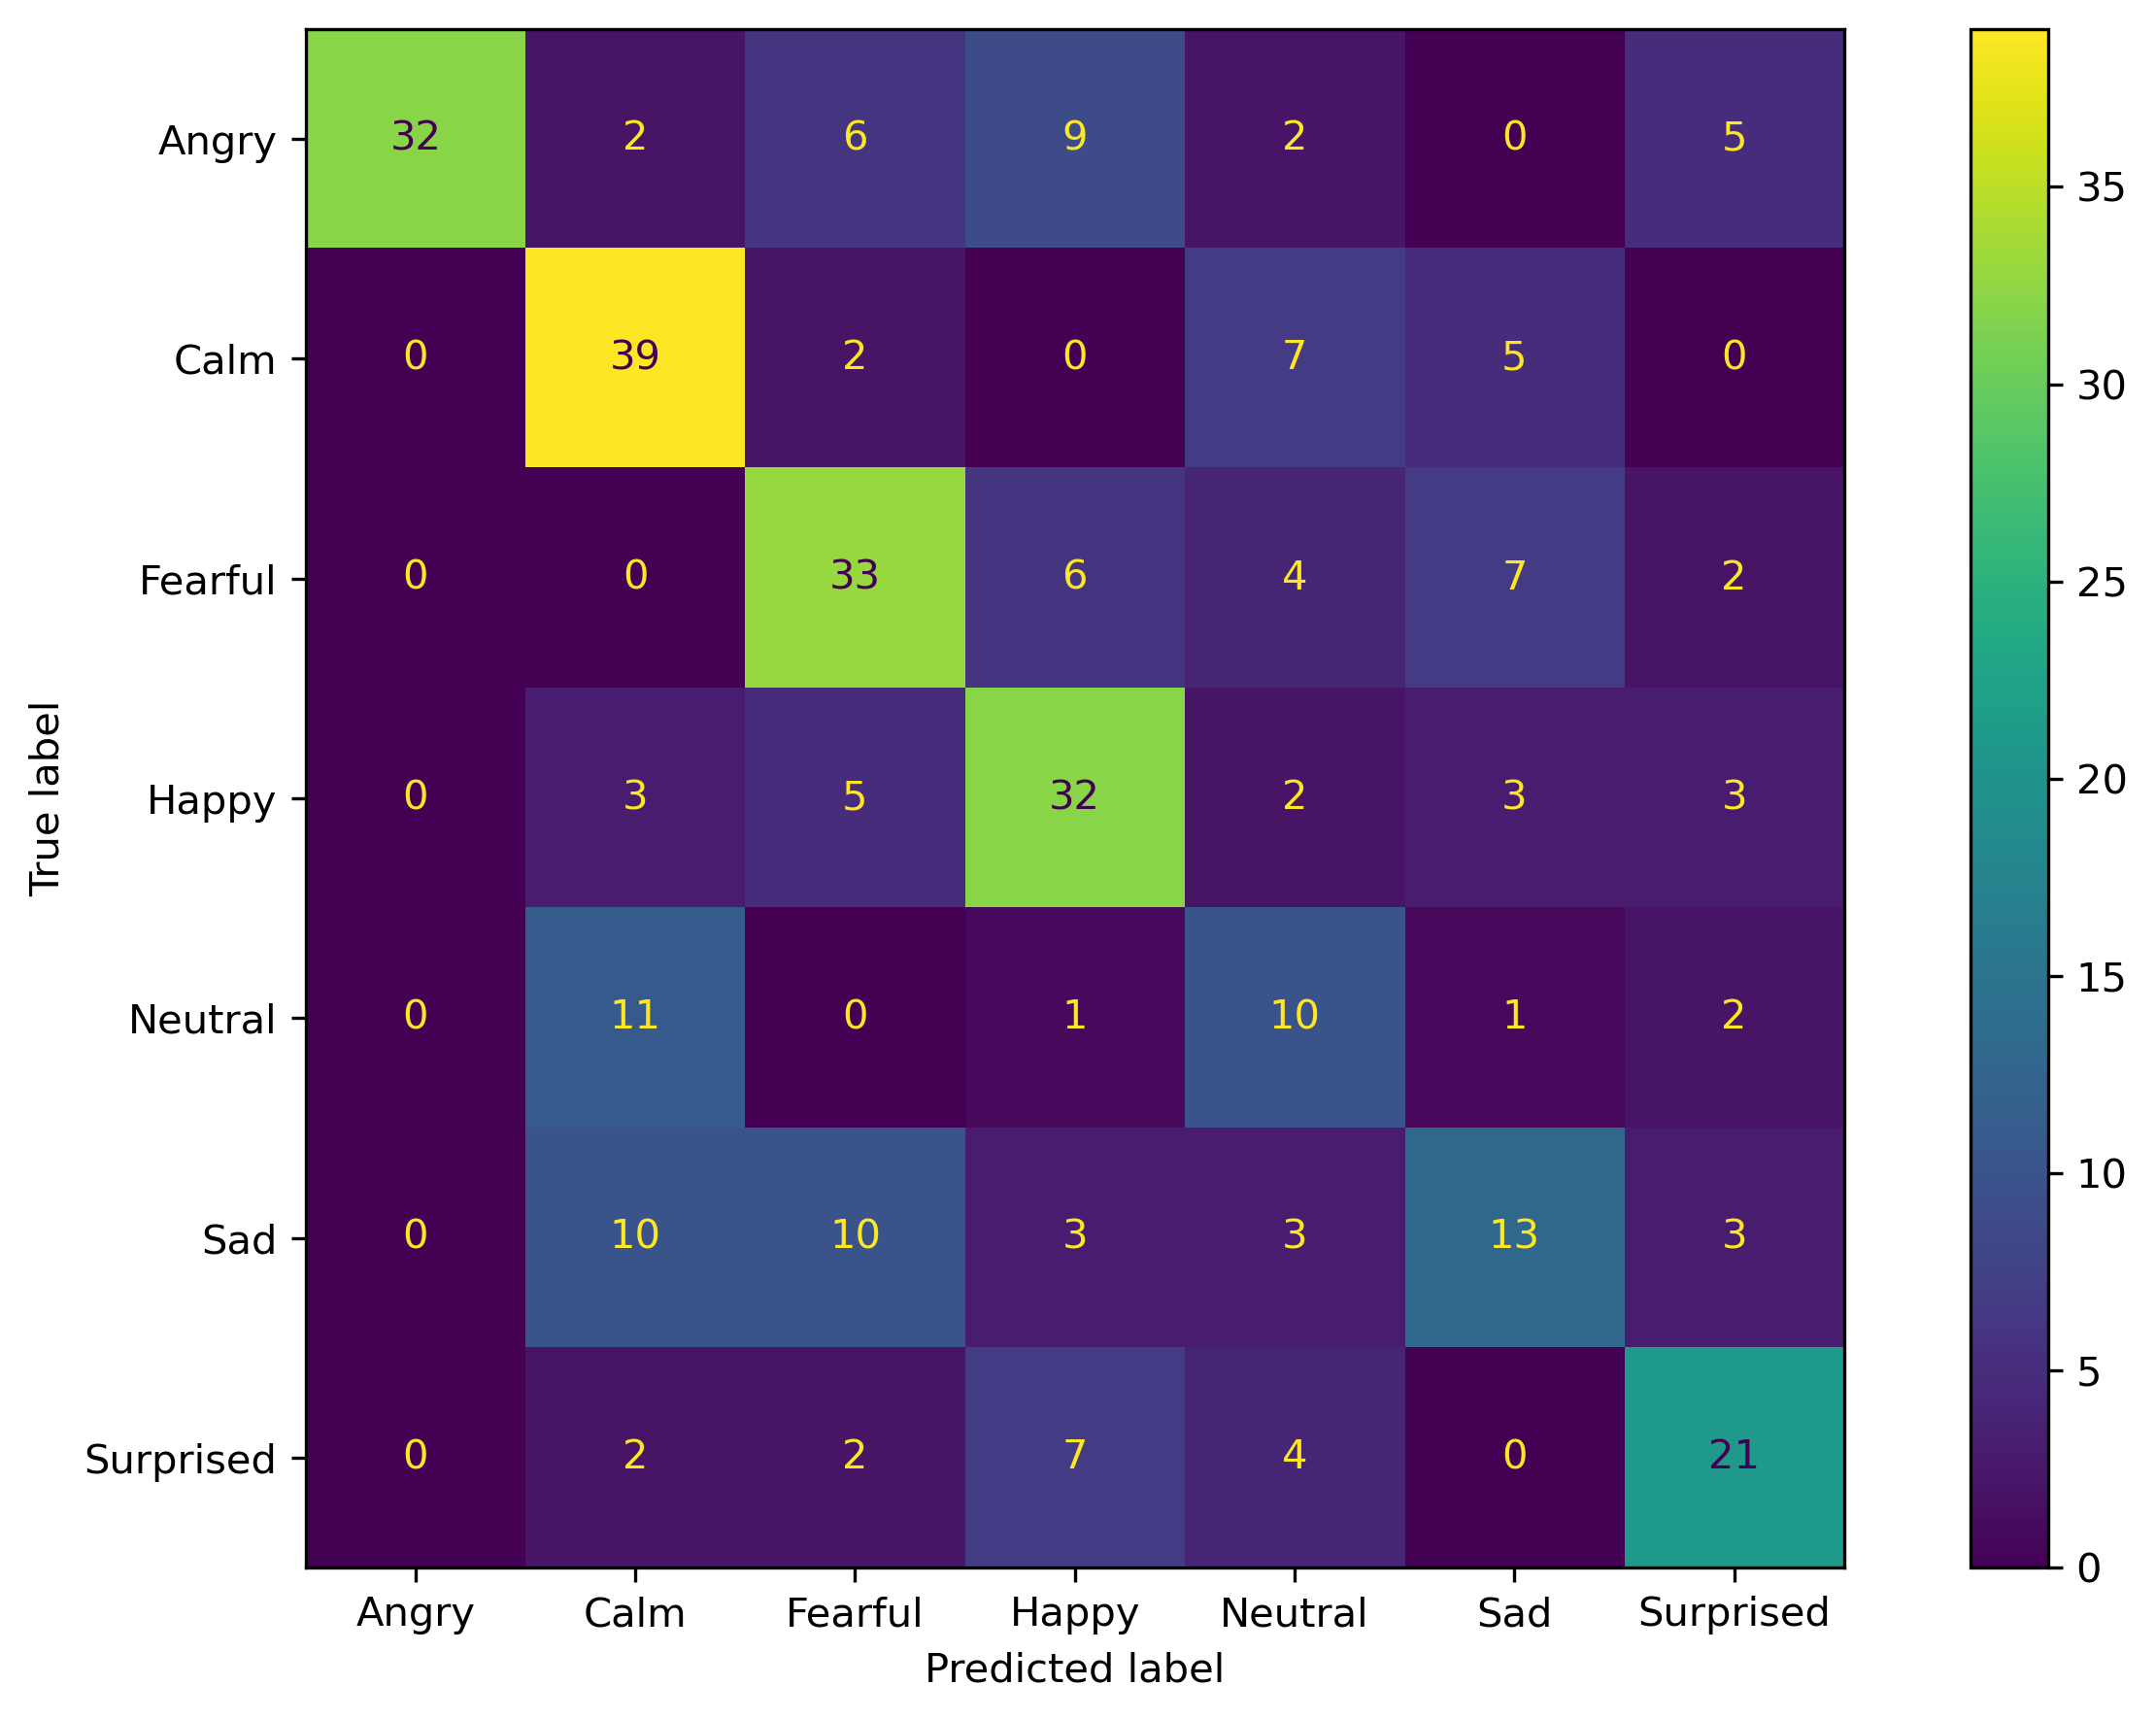

In [20]:

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Angry','Calm','Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised'])
fig, ax = plt.subplots(figsize=(9,6), dpi =300)
cmd.plot(ax=ax)
plt.tight_layout()
plt.savefig("Emotions.png")
